### Large-scale GP

Predictive mean and variance of GPR model:
$$
m(x_*) = \mathbf{k}^T \mathbf{K}_y^{-1} \mathbf{y},
$$
$$
\sigma^2(x_*) = k(x_*, x_*) - \mathbf{k}^T\mathbf{K}_y^{-1}\mathbf{k}
$$

**Issue**: the computational complexity is $\mathcal{O}(N^3)$, where $N$ is the training size.

### Nystrom approximation

Idea: introduce inducing points $(X_u, \mathbf{u})$ which are used for low-rank approximation of covariance matrix:
$$
\mathbf{K} \approx \mathbf{K}_{NM} \mathbf{K}_{MM}^{-1} \mathbf{K}_{MN}, \quad \mathbf{K}_{NM} = k(X, X_u), \mathbf{K}_{MM} = k(X_u, X_u), \mathbf{K}_{MN} = k(X_u, X)
$$

Predictive distribtion:
$$
f_* \; | \; x_*, X, \mathbf{y} \sim \mathcal{N}\left (m(x_*), \; \sigma^2(x_*)\right ),
$$
$$
m(x_*) = \mathbf{k}^T \left (\mathbf{K}_{NM}\mathbf{K}_{MM}^{-1} \mathbf{K}_{MN} + \sigma_n^2 I \right )^{-1} \mathbf{y}
$$
$$
\sigma^2(x_*) = k(x_*, x_*) - \mathbf{k}^T\left (\mathbf{K}_{NM}\mathbf{K}_{MM}^{-1}\mathbf{K}_{MN} + \sigma^2_n I \right)^{-1} k(x_*, x_*)
$$

Using Woodbury matrix identity we can calculate the inverse more efficiently:
$$
\left (\sigma_n^2 I + \mathbf{K}_{NM}\mathbf{K}_{MM}^{-1} \mathbf{K}_{MN} \right)^{-1} = \sigma_n^{-2} \left (
I - \mathbf{K}_{NM} \left (\sigma_n^2 \mathbf{K}_{MM} + \mathbf{K}_{MN} \mathbf{K}_{NM} \right )^{-1} \mathbf{K}_{MN}
\right )
$$

The computational complexity is $\mathcal{O}(NM^2)$.

In [1]:
from __future__ import print_function

import pandas as pd
import numpy as np
import GPy
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn import svm

from matplotlib import pyplot

%matplotlib notebook

For convenience we wrap GPy model to have sklearn-like API to use it in `cross_val_predict()` function from sklearn

Note, that in this implementation we generate random inducing inputs and fix them. However, inducing points can be optimized.

In [2]:
from sklearn.base import BaseEstimator

class SparseGPModel(BaseEstimator):
    def __init__(self, kernel, num_inducing=100):
        self.kernel_ = kernel
        self.num_inducing = num_inducing
        
    def fit(self, X, y):
        idx = np.random.permutation(X.shape[0])
        Z = X[idx[:self.num_inducing]]
        self.model_ = GPy.models.SparseGPRegression(X, y, kernel=self.kernel_, Z=Z)
        self.model_.inducing_inputs.fix()

        self.model_.optimize(max_iters=100)
        
    def predict(self, X):
        prediction, _ = self.model_.predict(X)
        return prediction
        
    def score(self, X, y):
        prediction = self.predict(X)
        return r2_score(y, prediction)

Let's load house pricing data again.

In [3]:
data = np.loadtxt('house_pricing.csv')

scaler = StandardScaler()

X = scaler.fit_transform(data[:, :-1])
y = data[:, -1:]
y_log = np.log(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [6]:
%%time
kernel = GPy.kern.RBF(X.shape[1])

model = SparseGPModel(kernel, num_inducing=100)
prediction = cross_val_predict(model, X, np.log1p(y), cv=3, n_jobs=1)

CPU times: user 15.8 s, sys: 18.2 s, total: 34 s
Wall time: 9.11 s


0.642030530827


<IPython.core.display.Javascript object>


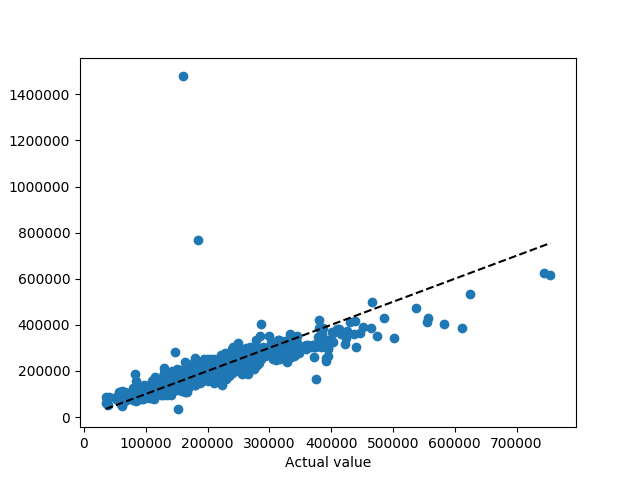

In [7]:
prediction = np.expm1(prediction)
R2 = r2_score(y, prediction)
print(R2)

def scatter_plot(y_test, prediction):
    pyplot.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k')
    pyplot.scatter(y_test, prediction)
    pyplot.xlabel('Actual value')
    pyplot.ylabel('Predicted value')
    pyplot.show()
    
scatter_plot(y, prediction)

### Task

For different number of inducing points (100, 200, 300, 500) build GP model and plot figure of how model accuracy and building time changes.

In [15]:
######## Your code here ########
import time

n_inducing = [100, 200, 300, 500]
errors = []
times = []

for n in n_inducing:
    kernel = GPy.kern.RBF(X.shape[1])
    model = SparseGPModel(kernel, num_inducing=n)
    t = time.time()
    prediction = np.expm1(cross_val_predict(model, X, np.log1p(y), cv=3, n_jobs=1))
    times.append(time.time() - t)
    errors.append(mean_squared_error(y, prediction))

 /home/yermek/.local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:160: RuntimeWarning:overflow encountered in true_divide
 /home/yermek/.local/lib/python3.5/site-packages/GPy/kern/src/rbf.py:35: RuntimeWarning:overflow encountered in square
 /home/yermek/.local/lib/python3.5/site-packages/GPy/kern/src/rbf.py:38: RuntimeWarning:invalid value encountered in multiply


Plot figures

<IPython.core.display.Javascript object>


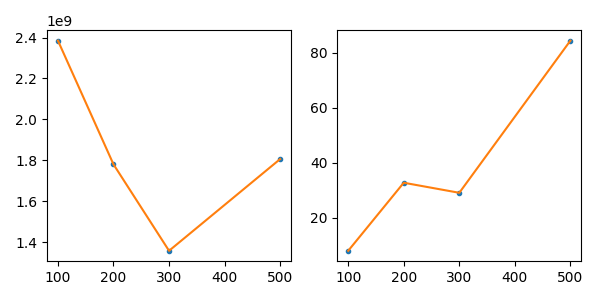

In [16]:
figure, ax = pyplot.subplots(1, 2, figsize=(6, 3))
ax[0].plot(n_inducing, errors, '.', label='R2')
ax[0].plot(n_inducing, errors, '-', label='R2')
ax[1].plot(n_inducing, times, '.', label='Training time')
ax[1].plot(n_inducing, times, '-', label='Training time')
figure.tight_layout()
pyplot.show()

### Random Fourier Features

Idea: shift-invariant kernel can be represented as
$$
k(x, y) = k(x - y) = \int p(w) e^{jw^T(x - y)} dw
$$

Let's calculate integral approximately by Monte Carlo
$$
k(x, y) \approx \frac{1}{M} \sum_{i=1}^M \phi_i^T(x) \phi_i(y),
$$
where $\phi_i(x) = \sqrt{2}\cos(w^Tx + b)$, $w \sim p(w), b \sim Uniform([0, 2\pi])$.

This means that the covariance matrix is approximated by $\mathbf{K} = \Phi \Phi^T$, where $\Phi = \|\boldsymbol{\phi}(x_i)\|_{i = 1}^N, \quad \boldsymbol{\phi}(x) = (\phi_1(x), \ldots, \phi_M(x))$

So, go back from functional space view to weight-space view:
$$
y = \beta^T\phi(x) + \varepsilon, \quad \beta \sim \mathcal{N}(0, \; \Sigma), \quad \varepsilon \sim \mathcal{N}(0, \; \sigma_n^2)
$$
The predictive distribution in this case:
$$
f_* \; | \; x_*, X, \mathbf{y} = \mathcal{N}\left (\frac{1}{\sigma_n^2}\boldsymbol{\phi}(x_*)^TA^{-1}\Phi^T \mathbf{y},\;
\boldsymbol{\phi}(x_*)^T A^{-1}\boldsymbol{\phi}(x_*)
\right ), \quad A = \sigma_n^{-2}\Phi^T \Phi + \Sigma^{-1}
$$
The computational complexity is $\mathcal{O}(NM^2)$.

### Task

Implement generation of RFF

In [17]:
from sklearn.base import BaseEstimator
from sklearn.exceptions import NotFittedError
from scipy.stats import cauchy, laplace
from sklearn.metrics.pairwise import rbf_kernel, laplacian_kernel


class RFF(BaseEstimator):
    def __init__(self, gamma=1, n_components=50, kernel="rbf"):
        self.gamma = gamma
        self.kernel = kernel
        # Number of features (Monte Carlo samples)
        self.n_components = n_components
        self.fitted = False
        
    def fit(self, X, y=None):
        """ Generates MonteCarlo random samples """
        d = X.shape[1]
        #Generate D iid samples from p(w)
        if self.kernel == "rbf": # for RBF kernel p(w) ~ exp(-gamma * w^2)
            self.w = np.sqrt(2 * self.gamma) * np.random.normal(size=(self.n_components, d), )
        elif self.kernel == "laplace": # for Laplace distribution p(w) ~ Cauchy(gamma)
            self.w = cauchy.rvs(scale=self.gamma, size=(self.n_components, d))
        
        #Generate D iid samples from Uniform(0,2*pi) 
        self.u = 2 * np.pi * np.random.rand(self.n_components)
        self.fitted = True
        return self
    
    def transform(self, X):
        """ Transforms the data X (n_samples, n_features) to the new map space Z(X) (n_samples, n_components)"""
        if not self.fitted:
            raise NotFittedError("RBF_MonteCarlo must be fitted beform computing the feature map Z")
        #Compute feature map Z(x):
        Z = np.sqrt(2 / self.n_components) * np.cos((X.dot(self.w.T) + self.u[np.newaxis, :]))
        return Z
    
    def compute_kernel(self, X):
        """ Computes the approximated kernel matrix K """
        if not self.fitted:
            raise NotFittedError("RBF_MonteCarlo must be fitted beform computing the kernel matrix")
        Z = self.transform(X)
        K = Z.dot(Z.T)
        return K

Now, generate 100 random points from [0, 1]^d, calculate exact kernel matrix for RBF and Exponential kernels,
calculate their approximations using RFF and check that they are close.

In [18]:
######## Your code here ########
dim = 4
rbf = GPy.kern.RBF(dim, lengthscale=1 / np.sqrt(2)).K

exponential = GPy.kern.Exponential(dim).K

np.random.seed(42)
x = np.random.rand(100, dim)

######## Your code here ########
# 1. Calculate exact kernel matrix for RBF kernel and Exponential kernels
# 2. Calculate approximations using RFF
# 3. Calculate approximation error ||K_exact - K_approx|| / ||K_exact|| and check whether the norm is small

rbf_exact = rbf(x)
rbf_approx = RFF(n_components=1000).fit(x).compute_kernel(x)

print(np.linalg.norm(rbf_approx - rbf_exact) / np.linalg.norm(rbf_exact))


0.0545765500688


### Task

For different number of inducing points (100, 200, 300, 500) build GP model and plot figure of how model accuracy and building time changes.

In [21]:
######## Your code here ########
# Hint: use Pipeline from sklearn
from sklearn.pipeline import Pipeline

n_inducing = [100, 200, 300, 500]
errors = []
times = []

for n in n_inducing:
    model = Pipeline([('rff', RFF(n_components=n)),
                      ('svm', svm.LinearSVR())])
    t = time.time()
    prediction = cross_val_predict(model, X, np.log1p(y.ravel()), cv=3, n_jobs=1)
    times.append(time.time() - t)
    errors.append(mean_squared_error(y, prediction))


Plot figures

<IPython.core.display.Javascript object>


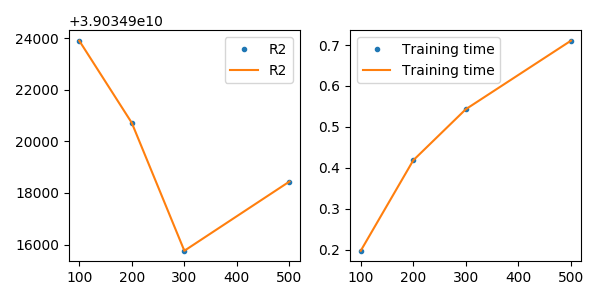

In [22]:
figure, ax = pyplot.subplots(1, 2, figsize=(6, 3))
ax[0].plot(n_inducing, errors, '.', label='R2')
ax[0].plot(n_inducing, errors, '-', label='R2')
ax[0].legend(loc='best')
ax[1].plot(n_inducing, times, '.', label='Training time')
ax[1].plot(n_inducing, times, '-', label='Training time')
ax[1].legend(loc='best')
figure.tight_layout()

pyplot.show()